In [1]:
# Title: BUILDING A HOTEL RECOMMENDATION SYSTEM USING COLLABORATIVE FILTERING WITH BENCHMARKING OF ML ALGORITHMS 
# Import libraries
import sys
import os
import warnings
import math
import random
from datetime import datetime
import time as t
from time import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise import SVD, SVDpp, SlopeOne, NMF, NormalPredictor, KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore,  BaselineOnly, CoClustering
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise import dump

In [2]:
# load hotel reviews information
df_hotels = pd.read_csv('HotelReviews_TA.csv', engine='python')
print(df_hotels.shape)
print (df_hotels.columns)



(16699, 12)
Index(['id', 'username', 'type', 'date', 'title', 'text', 'rating',
       'helpfulness', 'total_points', 'Hotel_name', 'Url', 'City'],
      dtype='object')


In [3]:
df_hotels.head()

,id,username,type,date,title,text,rating,helpfulness,total_points,Hotel_name,Url,City
0,1,007solotraveler,Hotels,4/8/2013,Good Choice and would be suitable for a family,Decent Hotel next to station so good location ...,4,1.0,101,"Radisson Blu Royal Viking Hotel, Stockholm",http://www.tripadvisor.com/Hotel_Review-g18985...,Stockholm
1,2,007solotraveler,Hotels,4/8/2013,Modern and Chic - suitable both family and bus...,Excellent Hotel - well situated for getting ro...,5,0.0,100,Radisson Blu Waterfront Hotel,http://www.tripadvisor.com/Hotel_Review-g18985...,Stockholm
2,4,007solotraveler,Hotels,7/9/2012,Family stay,Stayed for 3 nights in MIami - stayed here due...,4,0.0,100,Hilton Miami Airport,http://www.tripadvisor.com/Hotel_Review-g34438...,Miami
3,6,007solotraveler,Hotels,9/7/2011,Great Hotel - but is in need of some T&C!,Having read numerous poor reviews I was going ...,4,3.0,103,Crowne Plaza Hotel San Diego - Mission Valley,http://www.tripadvisor.com/Hotel_Review-g60750...,San Diego
4,7,007solotraveler,Hotels,9/6/2011,Great Location and fab hotel,I&acute;ve stayed here a few times over the la...,5,1.0,101,Hilton San Francisco Union Square,http://www.tripadvisor.com/Hotel_Review-g60713...,San Francisco


In [4]:
# load hotel reviews information
df_users = pd.read_csv('Users_TA.csv', engine='python')
print(df_users.shape)
print (df_users.columns)

(7034, 19)
Index(['username', 'ageRange', 'gender', 'location', 'travelStyle',
       'reviewerBadge', 'registerDate', 'numHotelsReviews', 'numRestReviews',
       'numAttractReviews', 'numFirstToReview', 'numRatings', 'numPhotos',
       'numForumPosts', 'numArticles', 'numCitiesBeen', 'totalPoints',
       'contribLevel', 'numHelpfulVotes'],
      dtype='object')


In [5]:
#check unique hotels and users and calculate percentage of data sparsity
n_users = df_hotels.username.unique().shape[0]
n_hotels = df_hotels.Hotel_name.unique().shape[0]

print('Number of unique users: {}'.format(n_users))
print('Number of unique hotels: {}'.format(n_hotels))
print('Sparsity Precentage: {:4.3f}%'.format(float(df_hotels.shape[0]) / float(n_users*n_hotels) * 100))

Number of unique users: 1098
Number of unique hotels: 12736
Sparsity Precentage: 0.119%


In [6]:
print(df_users.shape)
print(df_hotels.shape)

(7034, 19)
(16699, 12)


In [7]:
#look at users
df_users.head()

,username,ageRange,gender,location,travelStyle,reviewerBadge,registerDate,numHotelsReviews,numRestReviews,numAttractReviews,numFirstToReview,numRatings,numPhotos,numForumPosts,numArticles,numCitiesBeen,totalPoints,contribLevel,numHelpfulVotes
0,007solotraveler,35-49,male,liverpool,NaN,Contributor,6/1/2010,10.0,1.0,1.0,NaN,6.0,NaN,NaN,NaN,8.0,1240.0,3,10
1,0BKI0,25-34,female,Bristol,"Foodie, Nature Lover, Urban Explorer",Contributor,8/1/2009,11.0,7.0,NaN,NaN,1.0,10.0,NaN,NaN,11.0,2117.0,3,12
2,1010101,NaN,NaN,uk,NaN,NaN,3/1/2009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,0
3,10179k79,NaN,NaN,"Berlin, Germany",NaN,Top Contributor,5/1/2008,54.0,1.0,NaN,3.0,2.0,8.0,NaN,NaN,48.0,5808.0,5,58
4,10onwoodford,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0


In [8]:
# Check null values in the users dataset
df_users.isnull().sum()

username                0
ageRange             2248
gender               1735
location              203
travelStyle          3532
reviewerBadge          86
registerDate           81
numHotelsReviews       89
numRestReviews       1152
numAttractReviews    2164
numFirstToReview     1838
numRatings           2521
numPhotos            3358
numForumPosts        4433
numArticles          6798
numCitiesBeen          91
totalPoints            81
contribLevel            0
numHelpfulVotes         0
dtype: int64

In [9]:
# Check null values in the Hotel review dataset
df_hotels.isnull().sum()

id                 0
username           0
type               0
date               0
title              0
text               0
rating             0
helpfulness     3477
total_points       0
Hotel_name         0
Url                0
City               0
dtype: int64

In [10]:
# Check number of nonzeros
df_users.astype(bool).sum(axis=0)

username             7034
ageRange             7034
gender               7034
location             7034
travelStyle          7034
reviewerBadge        7034
registerDate         7034
numHotelsReviews     7034
numRestReviews       7034
numAttractReviews    7034
numFirstToReview     7034
numRatings           7034
numPhotos            7034
numForumPosts        7034
numArticles          7034
numCitiesBeen        7034
totalPoints          7031
contribLevel         6949
numHelpfulVotes      6901
dtype: int64

In [11]:
# Check number of nonzeros
df_hotels.astype(bool).sum(axis=0)

id              16699
username        16699
type            16699
date            16699
title           16699
text            16699
rating          16699
helpfulness     11767
total_points    16699
Hotel_name      16699
Url             16699
City            16699
dtype: int64

(array([2773., 1780.,  912.,  492.,  315.,  210.,  129.,   95.,   61.,
         44.]), array([  1. ,  10.9,  20.8,  30.7,  40.6,  50.5,  60.4,  70.3,  80.2,
        90.1, 100. ]), <a list of 10 Patch objects>)


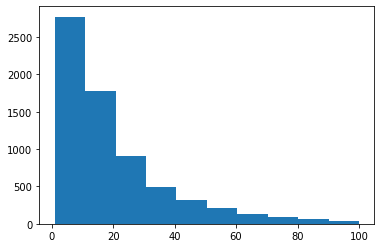

In [12]:
# Plot Histogram of number of users with the no of hotel reviews <=100
print(plt.hist(df_users.numHotelsReviews[df_users.numHotelsReviews<=100]))


In [13]:
# Print cities that the hotel belong to:
df_hotels.City.head(20)

0         Stockholm
1         Stockholm
2             Miami
3         San Diego
4     San Francisco
5        San Simeon
6           Gatwick
7            Sutton
8            London
9            London
10           London
11           Berlin
12     Mawgan Porth
13           London
14         Sorrento
15           Exeter
16           London
17    East Harptree
18          Pompeii
19       Ilfracombe
Name: City, dtype: object

In [14]:
df_hotels.describe()

,id,rating,helpfulness,total_points
count,16699.000000,16699.000000,13222.000000,16699.000000
mean,16173.956345,3.966764,1.442520,101.142164
std,9327.556988,1.005511,2.518186,2.316011
min,1.000000,1.000000,0.000000,100.000000
25%,8207.500000,3.000000,0.000000,100.000000
50%,16151.000000,4.000000,1.000000,100.000000
75%,24267.000000,5.000000,2.000000,101.000000
max,32619.000000,5.000000,86.000000,186.000000


(array([ 453.,    0.,  965.,    0.,    0., 3115.,    0., 6317.,    0.,
        5849.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 10 Patch objects>)

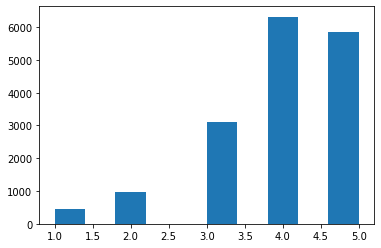

In [15]:
# Plot histogram of hotel ratings
plt.hist(df_hotels.rating)

In [16]:
# Encode the username and Hotel_name into numbers from 0 to n-1 using LabelEncoder

user_enc = LabelEncoder()
df_hotels['userid'] = user_enc.fit_transform(df_hotels['username'].values)
n_users = df_hotels['userid'].nunique()

hotel_enc = LabelEncoder()
df_hotels['hotelid'] = hotel_enc.fit_transform(df_hotels['Hotel_name'].values)
n_hotels = df_hotels['hotelid'].nunique()

# Convert ratings to float
df_hotels['rating'] = df_hotels['rating'].values.astype(np.float32)

#Calculate minimum and maximum rating
min_rating = min(df_hotels['rating'])
max_rating = max(df_hotels['rating'])

# Display no of users, no of hotels, minimum and maximum rating
n_users, n_hotels, min_rating, max_rating
print ("No of Users:" + str (n_users))
print ("No of Hotels:" + str (n_hotels))
print ("Minimum Users Rating:" + str (min_rating))
print ("Maximum Users Rating:" + str (max_rating))

No of Users:1098
No of Hotels:12736
Minimum Users Rating:1.0
Maximum Users Rating:5.0


In [17]:
# clean user skewness-remove
df_users.numRatings =  pd.Series([math.log(x+1) for x in df_users.numRatings])
df_users.numHotelsReviews = pd.Series([math.log(x+1) for x in df_users.numHotelsReviews])
df_users.numHelpfulVotes =  pd.Series([math.log(x+1) for x in df_users.numHelpfulVotes])

In [18]:
#Check to see if the user has given duplicate reviews for the same hotel
a = df_hotels.groupby(['Hotel_name','username']).agg(['count']).reset_index()
a.head(5)

,Hotel_name,username,id,type,date,title,text,rating,helpfulness,total_points,Url,City,userid,hotelid
,,,count,count,count,count,count,count,count,count,count,count,count,count
0,10 The Coffee House,DorsetTravelmad,1,1,1,1,1,1,0,1,1,1,1,1
1,11@Century Hotel,AlvinTSingapore,2,2,2,2,2,2,2,2,2,2,2,2
2,137 Pillars House,Bird-Bird-Blogger,1,1,1,1,1,1,1,1,1,1,1,1
3,15 Church Street Bed & Breakfast - Phillips-Ya...,Bear_Eskimo,1,1,1,1,1,1,1,1,1,1,1,1
4,16 Beach Street Bed and Breakfast,Anrmd,2,2,2,2,2,2,2,2,2,2,2,2


In [19]:
# Count of no of users with multiple reviews for the same hotel
tmp = a.rating.sort_values(by = 'count',ascending = False).reset_index()
tmp[tmp['count'] >1].shape 

(332, 2)

In [20]:
# Display the user index of multiple reviews
multi_review_user_idx = tmp[tmp['count'] >1]
multi_review_user_idx = multi_review_user_idx['index']
multi_review_user_idx

0       3001
1       4872
2       1782
3       6406
4       6187
       ...  
327     8104
328    14296
329    10280
330    14301
331     6071
Name: index, Length: 332, dtype: int64

In [21]:
# Use users latest rating as the final rating

for idxx in range(len(multi_review_user_idx)):
    tmp = df_hotels[(df_hotels.username == a.loc[multi_review_user_idx[idxx],'username'][0]) &
           (df_hotels.Hotel_name == a.loc[multi_review_user_idx[idxx],'Hotel_name'][0])].sort_values(
        by = 'date',ascending = True)
    
    df_hotels.drop(tmp.index[0:len(tmp.index)-1],inplace=True)
    

In [22]:
# check if all duplicated ratings are removed

b = df_hotels.groupby(['Hotel_name','username']).agg(['count']).reset_index()
tmp = b.rating.sort_values(by = 'count',ascending = False).reset_index()
tmp[tmp['count'] >1].shape

(0, 2)

In [23]:
#Check to see duplicated ratings are removed 
tmp = df_hotels.groupby(['Hotel_name','username']).agg(['count']).reset_index()
tmp.head(5)

,Hotel_name,username,id,type,date,title,text,rating,helpfulness,total_points,Url,City,userid,hotelid
,,,count,count,count,count,count,count,count,count,count,count,count,count
0,10 The Coffee House,DorsetTravelmad,1,1,1,1,1,1,0,1,1,1,1,1
1,11@Century Hotel,AlvinTSingapore,1,1,1,1,1,1,1,1,1,1,1,1
2,137 Pillars House,Bird-Bird-Blogger,1,1,1,1,1,1,1,1,1,1,1,1
3,15 Church Street Bed & Breakfast - Phillips-Ya...,Bear_Eskimo,1,1,1,1,1,1,1,1,1,1,1,1
4,16 Beach Street Bed and Breakfast,Anrmd,1,1,1,1,1,1,1,1,1,1,1,1


In [24]:
# Display sample hotel review text for the first user
df_hotels.text[0]

'Decent Hotel next to station so good location for getting round Stockholm - room a little on the small size - due for a refurbishment - but was still comfortable - room was quiet.\n\nBreakfast Buffet good of a morning though not quite as good as the Readisson Waterfront round the corner.\n\nStayed on the 6th floor in a corner room near the lifts and staircase - could smell the chlorine coming from the pool in the basement! in the corrindor though not in the room.\n\nWould recommend it'

In [25]:
df_hotels.columns

Index(['id', 'username', 'type', 'date', 'title', 'text', 'rating',
       'helpfulness', 'total_points', 'Hotel_name', 'Url', 'City', 'userid',
       'hotelid'],
      dtype='object')

In [26]:
# Set the Users rating scale
reader = Reader(rating_scale=(1, 5))

# Create Surprise package datsets with userid, hotelid and ratings
data = Dataset.load_from_df(
    df_hotels[['userid', 'hotelid', 'rating']], reader)


In [27]:
# Colloborative filtering method using user hotel rating matrix
# BenchMarking different machine leerning algorithms from Surprise package for Colloborative filtering based Recommender systems
# To avoid bias, same parameters was given to all benchmarking algorithms, crossvalidation is set to 5 and no of jobs as 5.

# Applying KNN based algorithms to the user hotel rating matrix

# KNN_BASIC
knnbasic_cv = cross_validate(KNNBasic(), data, cv=5, n_jobs=5, verbose=False)
# Using KNN Mean
knnmeans_cv = cross_validate(KNNWithMeans(), data, cv=5, n_jobs=5, verbose=False)
# Using KNN Z-score
knnz_cv = cross_validate(KNNWithZScore(), data, cv=5, n_jobs=5, verbose=False)
# Using KNN Baseline
knnB_cv = cross_validate(KNNBaseline(), data, cv=5, n_jobs=5, verbose=False)

In [28]:
# Applying Matrix Factorisation based algorithms to the user hotel rating matrix
# Uising SVD
svd_cv = cross_validate(SVD(), data, cv=5, n_jobs=5, verbose=False)
# Uising SVDpp
svdpp_cv = cross_validate(SVDpp(), data, cv=5, n_jobs=5, verbose=False)
# Uising NMF
nmf_cv = cross_validate(NMF(), data, cv=5, n_jobs=5, verbose=False)


In [29]:
# Applying other Colloborative filtering based algorithms to the user hotel rating matrix
# Using Slope One
slope_cv = cross_validate(SlopeOne(), data, cv=3, n_jobs=5, verbose=False)
# Using Co-CLustering
coclus_cv = cross_validate(CoClustering(), data, cv=3, n_jobs=5, verbose=False)


In [30]:
# Display RMSE and MAE scores for all bechmarking algorithms

print('Benchmarking Algorithm')
print('---------------------------------')

print('Algorithm\t RMSE\t MAE')

print()
print("KNN-Based:")
print('KNN Basic', '\t', round(knnbasic_cv['test_rmse'].mean(), 3), '\t', round(knnbasic_cv['test_mae'].mean(), 3))
print('KNN Means', '\t', round(knnmeans_cv['test_rmse'].mean(), 3), '\t', round(knnmeans_cv['test_mae'].mean(), 3))
print('KNN ZScore', '\t', round(knnz_cv['test_rmse'].mean(), 3), '\t', round(knnz_cv['test_mae'].mean(), 3))
print('KNN Baseline', '\t', round(knnB_cv['test_rmse'].mean(), 3), '\t', round(knnB_cv['test_mae'].mean(), 3))
print()
print("Matrix Factorisation Based:")
print('SVD', '\t\t', round(svd_cv['test_rmse'].mean(), 3), '\t', round(svd_cv['test_mae'].mean(), 3))
print('SVDpp', '\t\t', round(svdpp_cv['test_rmse'].mean(), 3), '\t', round(svdpp_cv['test_mae'].mean(), 3))
print('NMF', '\t\t', round(nmf_cv['test_rmse'].mean(), 3), '\t', round(nmf_cv['test_mae'].mean(), 3))
print()
print("Other methods:")
print('SlopeOne', '\t', round(slope_cv['test_rmse'].mean(), 3), '\t', round(slope_cv['test_mae'].mean(), 3))
print('CoClustering', '\t', round(coclus_cv['test_rmse'].mean(), 3), '\t', round(coclus_cv['test_mae'].mean(), 3))

print()

Benchmarking Algorithm
---------------------------------
Algorithm	 RMSE	 MAE

KNN-Based:
KNN Basic 	 1.018 	 0.758
KNN Means 	 1.012 	 0.764
KNN ZScore 	 1.013 	 0.765
KNN Baseline 	 0.98 	 0.757

Matrix Factorisation Based:
SVD 		 0.971 	 0.758
SVDpp 		 0.971 	 0.759
NMF 		 1.098 	 0.837

Other methods:
SlopeOne 	 1.015 	 0.766
CoClustering 	 1.069 	 0.797



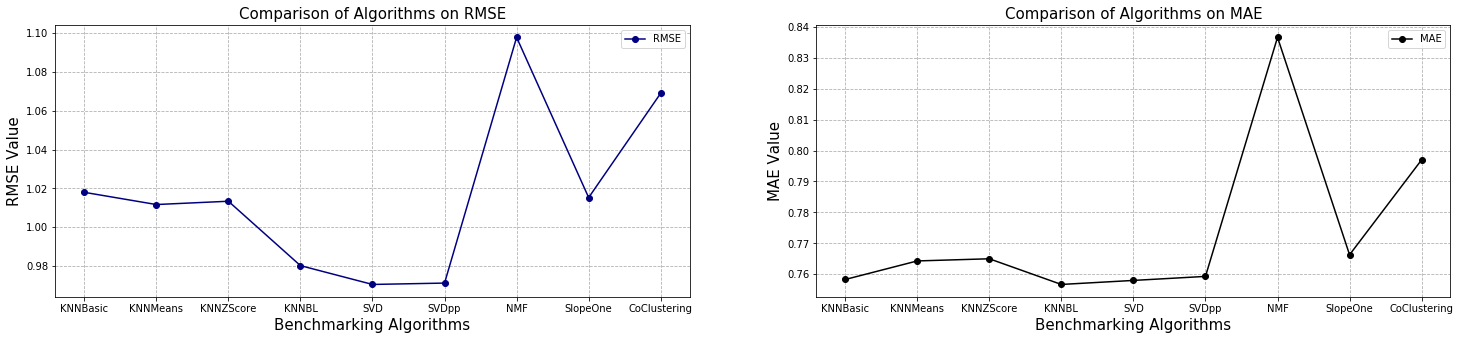

In [32]:
algo = ['KNNBasic', 'KNNMeans', 'KNNZScore', 'KNNBL','SVD', 'SVDpp', 'NMF', 'SlopeOne', 'CoClustering']
algos_cv = [knnbasic_cv, knnmeans_cv, knnz_cv,knnB_cv, svd_cv, svdpp_cv, nmf_cv, slope_cv, coclus_cv]

rmse_cv = [round(res['test_rmse'].mean(), 4) for res in algos_cv]
mae_cv = [round(res['test_mae'].mean(), 4) for res in algos_cv]

plt.figure(figsize=(25,5))

plt.subplot(1, 2, 1)
plt.title('Comparison of Algorithms on RMSE', loc='center', fontsize=15)
plt.plot(algo, rmse_cv, label='RMSE', color='navy', marker='o')
plt.xlabel('Benchmarking Algorithms', fontsize=15)
plt.ylabel('RMSE Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')

plt.subplot(1, 2, 2)
plt.title('Comparison of Algorithms on MAE', loc='center', fontsize=15)
plt.plot(algo, mae_cv, label='MAE', color='black', marker='o')
plt.xlabel('Benchmarking Algorithms', fontsize=15)
plt.ylabel('MAE Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')

plt.show()

In [33]:
# The bechmarking results shows that SVDpp, SVD, KNN-Baseline, BaselineOnly are the best algorithms 
# Based on RMSE score and MAE score SVD and SVDpp are the better algorithms comapred to other KNN and other algoritms
# We develop a COlloborative filtering Recommednder system using SVD snd SVDpp
# We need to fine tune the parameters to improve the SVD and SVDpp model.
# We use gridsearchCV algorithm to tune the hyperparameters

In [34]:
# create a dataframe to record grid search results
grid_search_result = pd.DataFrame(columns=['algorithm', 'param_grid', 'best_rmse_score', 'best_params', 'test_prediction_rmse', 'fit_time'])

In [35]:
# Data is shuffled to remove any biases.
import random
my_seed = 100
random.seed(my_seed)
# Data is suffuled to remove any biases.
raw_ratings = data.raw_ratings
random.shuffle(raw_ratings)

# Training_set is the training set which is 80% of the shuffled data
threshold = int(.8 * len(raw_ratings))
A_raw_ratings = raw_ratings[:threshold]
B_raw_ratings = raw_ratings[threshold:]

data.raw_ratings = A_raw_ratings

In [36]:
# Using SVDpp and we train the hyper parameters using GridSearchCV
# Parameters:Learning rate = 0.01, no of epochs is 23,25,27 
print('Using SVDpp')

n_epochs = [23, 25, 27]
lr_all = [0.01]
reg_all = [0.15, 0.2, 0.25]

param_grid = {'n_epochs': n_epochs, 'lr_all': lr_all, 'reg_all': reg_all}
gs1 = GridSearchCV(SVDpp, param_grid, measures=['rmse'], cv=5)
t0 = t.time()
gs1.fit(data)
t1 = t.time()
svdpp_lapsed = t1-t0

print("Best RMSE score: " + str (gs1.best_score['rmse']))
print("Best Model parameters: "+ str (gs1.best_params['rmse']))

algo = gs1.best_estimator['rmse']

# Retrain on the whole dataset
trainset = data.build_full_trainset()
algo.fit(trainset)

# Compute biased accuracy
svdpp_bpredictions = algo.test(trainset.build_testset())
print('Biased accuracy on the full training set,', end='   ')
accuracy.rmse(svdpp_bpredictions)

# Compute unbiased accuracy using testset, B_raw_ratings
testset = data.construct_testset(B_raw_ratings)  # testset is now the set B
svdpp_upredictions = algo.test(testset)
print('Unbiased accuracy on the full training set,', end=' ')
accuracy.rmse(svdpp_upredictions)

grid_search_result = grid_search_result.append({'algorithm':'SVDpp', 'param_grid':{'n_epochs':n_epochs, 'lr_all':lr_all, 'reg_all':reg_all}, 'best_rmse_score':gs1.best_score['rmse'], 'best_params':gs1.best_params['rmse'], 'test_prediction_rmse':accuracy.rmse(svdpp_upredictions), 'fit_time':svdpp_lapsed}, ignore_index=True)

Using SVDpp
Best RMSE score: 0.9766211575000648
Best Model parameters: {'n_epochs': 23, 'lr_all': 0.01, 'reg_all': 0.25}
Biased accuracy on the full training set,   RMSE: 0.6531
Unbiased accuracy on the full training set, RMSE: 0.9569
RMSE: 0.9569


In [37]:
# Using SVD algorithm and we train the hyper parameters using GridSearchCV
# Parameters:Learning rate = 0.01, no of epochs is 23,25,27
print('Using SVD')

n_epochs = [23, 25, 27]
lr_all = [0.01]
reg_all = [0.2]

param_grid = {'n_epochs':n_epochs, 'lr_all':lr_all, 'reg_all':reg_all}
gs3 = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5)
t0 = t.time()
gs3.fit(data)
t1 = t.time()
svd_lapsed = t1-t0

print("Best RMSE score: " + str(gs3.best_score['rmse']))
print("Best Model parameters: " + str(gs3.best_params['rmse']))

algo = gs3.best_estimator['rmse']

# retrain on the whole dataset
trainset = data.build_full_trainset()
algo.fit(trainset)

# Compute biased accuracy
svd_bpredictions = algo.test(trainset.build_testset())
print('Biased accuracy on the complete training set,', end='   ')
accuracy.rmse(svd_bpredictions)

# Compute unbiased accuracy using testset, B_raw_ratings
testset = data.construct_testset(B_raw_ratings)  # testset is now the set B
svd_upredictions = algo.test(testset)
print('Unbiased accuracy on the complete training set,', end=' ')
accuracy.rmse(svd_upredictions)

grid_search_result = grid_search_result.append({'algorithm':'SVD', 'param_grid':{'n_epochs':n_epochs, 'lr_all':lr_all, 'reg_all':reg_all}, 'best_rmse_score':gs3.best_score['rmse'], 'best_params':gs3.best_params['rmse'], 'test_prediction_rmse':accuracy.rmse(svd_upredictions), 'fit_time':svd_lapsed}, ignore_index=True)

Using SVD
Best RMSE score: 0.9770527867711918
Best Model parameters: {'n_epochs': 23, 'lr_all': 0.01, 'reg_all': 0.2}
Biased accuracy on the complete training set,   RMSE: 0.5546
Unbiased accuracy on the complete training set, RMSE: 0.9559
RMSE: 0.9559


In [38]:
grid_search_result.head()

,algorithm,param_grid,best_rmse_score,best_params,test_prediction_rmse,fit_time
0,SVDpp,"{'n_epochs': [23, 25, 27], 'lr_all': [0.01], '...",0.976621,"{'n_epochs': 23, 'lr_all': 0.01, 'reg_all': 0.25}",0.956923,370.738923
1,SVD,"{'n_epochs': [23, 25, 27], 'lr_all': [0.01], '...",0.977053,"{'n_epochs': 23, 'lr_all': 0.01, 'reg_all': 0.2}",0.955933,23.596644


In [39]:
# # Dump best algorithm and reload it.
# file_name = os.path.expanduser('surprise_SVD_model')
# dump.dump(file_name, algo=algo)
# _, loaded_algo = dump.load(file_name)


In [40]:
# Function to get top 10 recommended hotels

def get_top_n(predictions, n=10):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, hid, true_r, est, _ in predictions:
        top_n[uid].append((hid, est))

    # Then sort the predictions for each user and retrieve the 10 highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n


In [41]:
# We finally use the SVDpp algorithm as its the best from all the bench marking algorithms

from collections import defaultdict
# First train an SVDpp algorithm
data = Dataset.load_from_df(df_hotels[['userid', 'hotelid', 'rating']], reader)
trainset = data.build_full_trainset()
algo = loaded_algo
algo.fit(trainset)

# Than predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

top_n = get_top_n(predictions, n=10)

In [42]:
# Creating a pickle file
import pickle
filename = 'Top_Predictions1'
outfile = open(filename,'wb')
pickle.dump(top_n,outfile)
outfile.close()

# # saving the predicted top 10 recommendations of the SVD model with pickle
# with open("Top_Predictions", wb) as tp:
#     pickle.dump(top_n, tp)

In [43]:
top_n = pd.read_pickle("./Top_Predictions1")

In [44]:
# getting all hotels that a particular user reviewed
df_hotels.loc[df_hotels["userid"] == 100][[ "username","userid", "Hotel_name", "rating"]].reset_index(drop = True)

,username,userid,Hotel_name,rating
0,ARugby,100,BEST WESTERN Pontypool Metro Hotel,5.0
1,ARugby,100,Bush Sand and Sea,5.0
2,ARugby,100,Aoraki Court Motel at Aoraki/Mt Cook Village,5.0
3,ARugby,100,Lyons Rock Bed and Breakfast,5.0
4,ARugby,100,Hanoi Elegance Diamond Hotel,5.0
5,ARugby,100,Hotel Berg,5.0
6,ARugby,100,West Ham United Hotel,3.0
7,ARugby,100,Cromore Halt Inn,5.0
8,ARugby,100,Slebech Park,3.0


In [45]:
# getting the top 10 recommendations for a particular user
top_picks = top_n[100]
hotels, _ = zip(*top_picks)
top_suggestions = pd.DataFrame(columns = ["Hotel_name", "rating"])
for hotel in hotels:
    top_suggestions = top_suggestions.append(df_hotels.loc[df_hotels["hotelid"] == hotel][["Hotel_name", "rating"]], ignore_index = True)

top_hotels = top_suggestions.drop_duplicates(keep = 'last').reset_index(drop = True)
top_hotels.drop_duplicates(keep = 'last', subset = 'Hotel_name')

,Hotel_name,rating
1,Hilton London Tower Bridge,5.0
2,Hilton London Paddington,5.0
4,Pan Pacific Singapore,5.0
6,InterContinental Singapore,5.0
8,The Talbott Hotel,5.0
9,DoubleTree by Hilton London Heathrow,5.0
10,"The Langham, Hong Kong",5.0
11,Jaipur Marriott Hotel,5.0
12,Hilton Berlin,5.0
13,The Fairmont Olympic Seattle,5.0


In [46]:
# Second Approach
# Using both review text and user rating features to build a Matrix Factorisation based Colloborative filtering Recommender system

In [47]:
# Second Approach
# Using both review text and user rating features to build a Matrix Factorisation based Colloborative filtering Recommender system
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords 
from nltk.tokenize import WordPunctTokenizer
import string
import re

In [48]:
# Function for Text cleaning, remove stop words from the review text
def clean_text(text):
    text = text.translate(string.punctuation)
    
    ## Convert words to lower case and split them
    text = text.lower().split()
    
    ## Remove stop words
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops and len(w) >= 3]
    
    text = " ".join(text)
    
    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)    
    return text

In [49]:
# Create a dataframe with only necessary columns
hotel_data = df_hotels[['Hotel_name', 'username', 'rating', 'text']]

In [50]:
%%time
# Apply Clean text function and remove the stop words
hotel_data['text'] = hotel_data['text'].apply(clean_text)

Wall time: 14.5 s


C:\Users\Karthik\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [51]:
#Split dataset into train test with 80% Training and 20% for testing
Split_size=0.2
X_train, X_valid, y_train, y_valid = train_test_split(hotel_data['text'], hotel_data['Hotel_name'], test_size = Split_size) 

In [52]:
userid_df = hotel_data[['username','text']]
hotelid_df = hotel_data[['Hotel_name', 'text']]

In [53]:
userid_df = userid_df.groupby('username').agg({'text': ' '.join})
hotelid_df = hotelid_df.groupby('Hotel_name').agg({'text': ' '.join})


In [54]:
#Use TfidfVectorizer to create userid vectorizer
userid_vectorizer = TfidfVectorizer(tokenizer = WordPunctTokenizer().tokenize, max_features=1000)
userid_vectors = userid_vectorizer.fit_transform(userid_df['text'])
userid_vectors.shape

(1098, 1000)

In [55]:
#Use TfidfVectorizer to create Hotel id vectorizer
hotelid_vectorizer = TfidfVectorizer(tokenizer = WordPunctTokenizer().tokenize, max_features=1000)
hotelid_vectors = hotelid_vectorizer.fit_transform(hotelid_df['text'])
hotelid_vectors.shape

(12736, 1000)

In [56]:
# Create a pivot table for userid rating matrix
userid_rating_matrix = pd.pivot_table(hotel_data, values='rating', index=['username'], columns=['Hotel_name'])
userid_rating_matrix.shape

(1098, 12736)

In [57]:
userid_rating_matrix.head()

Hotel_name,10 The Coffee House,11@Century Hotel,137 Pillars House,15 Church Street Bed & Breakfast - Phillips-Yates-Snowden House,16 Beach Street Bed and Breakfast,1801 First Luxury Inn,1886 Crescent Hotel & Spa,1897 Beekman House,196 Bishopsgate,202 Modern Service Apartments,...,misc eatdrinksleep,naked Stables,nhow Rotterdam,"nyma, the New York Manhattan Hotel",pentahotel Leipzig,remm Hibiya,theWit - A DoubleTree by Hilton,uMhlanga Sands Resort,von Stackelberg Hotel Tallinn,"with AC, 1BR apt Champ de Mars Near the Eiffel T"
username,,,,,,,,,,,,,,,,,,,,,
007solotraveler,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0BKI0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10179k79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
124_10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12ReasonsWhy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
# Create two dataframes for userid and Hotel id

U = pd.DataFrame(userid_vectors.toarray(), index=userid_df.index, columns=userid_vectorizer.get_feature_names())
H = pd.DataFrame(hotelid_vectors.toarray(), index=hotelid_df.index, columns=hotelid_vectorizer.get_feature_names())


In [59]:
def matrix_factorization(R, U, H, steps=1, gamma=0.001,lamda=0.02):
    for step in range(steps):
        for i in R.index:
            for j in R.columns:
                if R.loc[i,j]>0:
                    eij=R.loc[i,j]-np.dot(U.loc[i],H.loc[j])
                    U.loc[i]=U.loc[i]+gamma*(eij*H.loc[j]-lamda*U.loc[i])
                    H.loc[j]=H.loc[j]+gamma*(eij*U.loc[i]-lamda*H.loc[j])
        e=0
        for i in R.index:
            for j in R.columns:
                if R.loc[i,j]>0:
                    e= e + pow(R.loc[i,j]-np.dot(U.loc[i],H.loc[j]),2)+lamda*(pow(np.linalg.norm(U.loc[i]),2)+pow(np.linalg.norm(H.loc[j]),2))
        if e<0.001:
            break
        
    return U,H

In [60]:
%%time
# Apply Matrix Factorization algorithm on the userid_rating_matrix, userid_vector and hotel_id vector matrices
U, H = matrix_factorization(userid_rating_matrix, U, H, steps=1, gamma=0.001,lamda=0.02)

C:\Users\Karthik\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """
C:\Users\Karthik\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':


Wall time: 15min 31s


In [61]:
#Store U, H and vectorizer in pickle file named as Reviewtext_recommendation.pkl
import pickle
output = open('Reviewtext_recommendation.pkl', 'wb')
pickle.dump(U,output)
pickle.dump(H,output)
pickle.dump(userid_vectorizer,output)
output.close()

In [67]:
# Prediction for input text
words = 'Hotel near to airport, with restaurants'
test_df= pd.DataFrame([words], columns=['text'])
test_df['text'] = test_df['text'].apply(clean_text)
test_vectors = userid_vectorizer.transform(test_df['text'])
test_v_df = pd.DataFrame(test_vectors.toarray(), index=test_df.index, columns=userid_vectorizer.get_feature_names())

predictHotelRating=pd.DataFrame(np.dot(test_v_df.loc[0],H.T),index=H.index,columns=['Rating'])
topRecommendations=pd.DataFrame.sort_values(predictHotelRating,['Rating'],ascending=[0])[:10]
topRecommendations


,Rating
Hotel_name,
Airlines Travel Hotel Shanghai Pudong Airport Branch,0.563156
Novotel Milano Linate Airport,0.548361
Montreal Airport Marriott In-Terminal Hotel,0.453559
Holiday Inn Express At JFK,0.422809
Quality Airport Hotel Dan,0.416919
Premier Inn Edinburgh Airport (Newbridge) Hotel,0.414938
Holiday Inn Express Hotel & Suites Los Angeles Airport Hawthorne,0.414623
Novotel Suites Paris CDG Airport Villepinte,0.401572
"Aloft Chennai, OMR - IT Expressway",0.393341


In [63]:
# Prediction and Accuracy test on Validation set
f = open('Reviewtext_recommendation.pkl', 'rb')
U, H, userid_vectorizer = pickle.load(f), pickle.load(f), pickle.load(f)

In [64]:
# Prediction and Accuracy test on Validation set
test_df = X_valid.to_frame()
test_df['text'] = test_df['text'].apply(clean_text)
test_vectors = userid_vectorizer.transform(test_df['text'])
test_v_df = pd.DataFrame(test_vectors.toarray(), index=test_df.index,
                         columns=userid_vectorizer.get_feature_names())


In [65]:
# Prediction ratings for the top recommended hotel
y_pred = []
for key, row in test_v_df.iterrows():
    predictHotelRating=pd.DataFrame(np.dot(row,H.T),index=H.index,columns=['Rating'])
    topRecommendations=pd.DataFrame.sort_values(predictHotelRating,['Rating'],ascending=[0])[:1]
    y_pred.append(topRecommendations.index[0])


In [68]:
#Calculate Accuracy of the validation set
from sklearn.metrics import accuracy_score
print('Accuracy for validation set is: ',accuracy_score(y_valid, y_pred))

Accuracy for validation set is:  0.9647131021785824
